# Practical 6.2: Convolutional autoencoder architectures
In this practical we will look at how to design a convolutional autoencoder architecture. For the encoder, we can use similar architectures as for common classification/regression networks (e.g. VGG-style). Typically, the decoder is then designed to "reverse" the structure of the encoder. For fully connected layers this is straightforward, but for convolutional or pooling layers this leaves some options.

### Imports

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist

import numpy as np
import matplotlib.pyplot as plt

## Data (MNIST)
We'll use MNIST as a simple example. Images are 28x28 pixels, but for convolutional autoencoders with strides or pooling, it is very convenient if the image size is a multiple of the stride/pool size. Typically, we use 2x2 strides/pooling, so we rescale the canvas size of MNIST from 28x28 to 32x32 (since 32=2^5), by padding zeros.

In [ ]:
# MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# normalise
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# change shape: (n, 28, 28) -> (n, 28, 28, 1)
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.reshape(x_test.shape + (1,))

# pad zeros to obtain canvas size of 32x32, i.e. shape is now (n, 32, 32, 1)
x_train = np.pad(x_train, pad_width=((0, 0), (2, 2), (2, 2), (0, 0)), mode="constant", constant_values=0)
x_test = np.pad(x_test, pad_width=((0, 0), (2, 2), (2, 2), (0, 0)), mode="constant", constant_values=0)

# get number of training samples, height, width, and depth values
n_train, height, width, depth = x_train.shape

11493376/11490434 [==============================] - 0s 0us/step


## VGG-like encoder
Let's make a simple VGG-like encoder with 2 convolutional blocks, each consisting of a single convolution and maxpooling, followed by two dense layers. We'll also include batch normalization.

Let's write the input and output shape of each layer in the comments, to get a better idea of the structure of the network.

In [ ]:
# input
x_in = layers.Input(shape=(height, width, depth), name="encoder_input")

# conv block 1
h = layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same",
                  activation='relu')(x_in)                    # (32, 32, 1)  -> (32, 32, 64)
h = layers.MaxPooling2D(pool_size=(2, 2), padding="same")(h)  # (32, 32, 64) -> (16, 16, 64)
h = layers.BatchNormalization()(h)                            # no change

# conv block 2
h = layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same",
                  activation='relu')(h)                       # (16, 16, 64)  -> (16, 16, 128)
h = layers.MaxPooling2D(pool_size=(2, 2), padding="same")(h)  # (16, 16, 128) -> (8, 8, 128)
h = layers.BatchNormalization()(h)                            # no change

# dense layers
h = layers.Flatten()(h)                                       # (8, 8, 128) -> (8*8*128,)
h = layers.Dense(256, activation="relu")(h)                   # (8*8*128,)  -> (256,)
h = layers.BatchNormalization()(h)                            # no change
h = layers.Dense(128, activation="relu")(h)                   # (256,) -> (128,)
h = layers.BatchNormalization()(h)                            # no change
encoded = layers.Dense(32, name="encoded")(h)                 # (128,) -> (32,) (encoding dimension)
# NOTE: no activation for the last layer, encoded representations are vectors of real numbers

## Decoder architecture: reversing the structure
For our decoder architecture, it seems natural to reverse the structure of the encoder, layer by layer. We could try some weight-tying between encoder and decoder, but typically this is not done; the encoder and decoder each have their own weights that are trained independently.

Reversing the structure of a fully connected layer is simple; use the input size of the encoder layer as the number of output units for the decoder layer.

To reverse convolutional layers (in particular when they are strided), we could use a transposed convolution (often mistakenly called "deconvolution") to reverse its structure. However, this is prone to creating unwanted artifacts, or the checkerboard effect (see https://distill.pub/2016/deconv-checkerboard/ for an excellent explanation). Therefore, we prefer to not use strided convolutions in the encoder, and we use MaxPooling2D to downsample the size of the activation maps. To reverse this downsampling, we can use the UpSampling2D layer in Keras (which is essentially nearest-neighbour interpolation as described and recommended in https://distill.pub/2016/deconv-checkerboard/). To "reverse" a non-strided convolution, we can then simply use another normal convolution, where we use the number of input activation maps (filters) of the encoder conv-layer as the number of output activation maps (filters) for the decoder conv-layer.

Now let's reverse the encoder architecture, making sure that we have the same change in shape for the hidden units, but reversed.

## ASSIGNMENT:
Design the decoder architecture, by reversing the encoder architecture. The reversed order of the shapes is already given as a guide.

In [ ]:
#### INSERT CODE HERE ####
#    reverse dense layers:
h = layers.Dense(128, activation='relu')(encoded)         # (32,) -> (128,) (encoding dimension)
h = layers.BatchNormalization()(h)                        # no change
h = layers.Dense(256, activation='relu')(h)               # (128, -> (256,)
h = layers.BatchNormalization()(h)                        # no change
h = layers.Dense(8*8*128, activation='relu')(h)           # (256,)     -> (8*8*128,)
h = layers.Reshape((8, 8, 128))(h)                         # (8*8*128,) -> (8, 8, 128)

#    reverse conv block 2:
h = layers.BatchNormalization()(h)                        # no change
h = layers.UpSampling2D(size=(2,2))(h)                    # (8, 8, 128  ) -> (16, 16, 128)
h = layers.Conv2D(64, kernel_size=(3,3),\
                 padding='same', activation='relu')(h)    # (16, 16, 128) -> (16, 16, 64)

#    reverse conv block 1:
h = layers.BatchNormalization()(h)                        # no change
h = layers.UpSampling2D(size=(2,2))(h)                    # (16, 16, 64) -> (32, 32, 64)
x_out = layers.Conv2D(1, kernel_size=(3,3),\
                 padding='same', activation='sigmoid')(h) # (32, 32, 64) -> (32, 32, 1)

# HINT: think about the activation for the last layer, which should represent
#       pixel values between 0 and 1
#### UNTIL HERE ####

## Compile, train, and test the model
Let's setup and compile the autoencoder, and do a quick test. We use some loss function to compare the original data with its reconstruction, so we use the training set both as input and target values.

In [ ]:
autoencoder = Model(x_in, x_out, name="autoencoder")
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

autoencoder.fit(x_train, x_train,
                epochs=20,
                batch_size=100,
                validation_data=(x_test, x_test))

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         

Reconstruct and visualise some images from the test set.

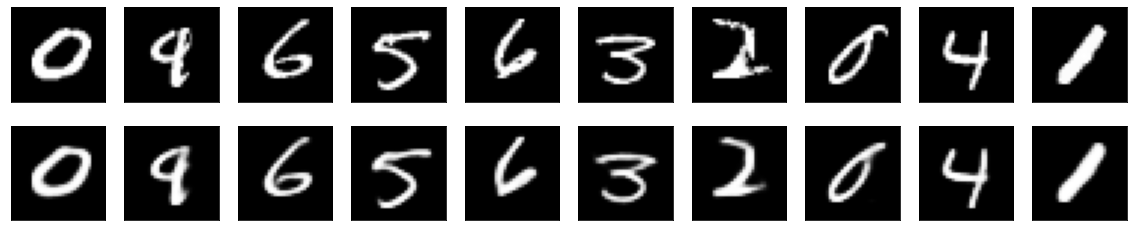

In [ ]:
n = 10  # number of images to plot
indices = np.random.choice(len(x_test), size=n, replace=False)
test_imgs = x_test[indices]
reconstr_imgs = autoencoder.predict(test_imgs)

plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_imgs[i].reshape(32, 32))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstr_imgs[i].reshape(32, 32))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()